In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import os

In [6]:
data = pd.read_excel('Online Retail.xlsx')

### Removing Duplicates
#### Sometimes you get the messy datasets. You have to deal with the duplicates, which will skew your analysis. In python,pandas offere drop_dupicates() function , which drop the duplicates or repeated values.

In [7]:
filtered_data = data[['Country','CustomerID']].drop_duplicates()

#### Let's jump into analysis

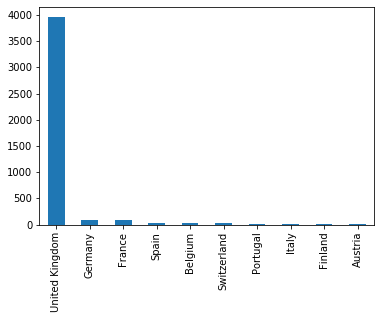

In [8]:
# Top ten country's customer
filtered_data.Country.value_counts()[:10].plot(kind='bar')

#### In the given datasets, you can see that most of the customers are from UK, so we can filter the datasets for United Kingdom's Customer

In [10]:
uk_data = data[data.Country=='United Kingdom']
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      495478 non-null object
StockCode      495478 non-null object
Description    494024 non-null object
Quantity       495478 non-null int64
InvoiceDate    495478 non-null datetime64[ns]
UnitPrice      495478 non-null float64
CustomerID     361878 non-null float64
Country        495478 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.0+ MB


#### describe() function returns the count, mean, standard deviation, minimum and maximum values and the quantiles of the data.

In [12]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


#### From here you can observe that some of the customers have ordered in negative quantity, which is not possible. So, you need to filter the quantity greater than zero.

In [15]:
uk_data = uk_data[(uk_data['Quantity'] >0)]
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486286 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      486286 non-null object
StockCode      486286 non-null object
Description    485694 non-null object
Quantity       486286 non-null int64
InvoiceDate    486286 non-null datetime64[ns]
UnitPrice      486286 non-null float64
CustomerID     354345 non-null float64
Country        486286 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.4+ MB


## Filter required Columns
### Here, you can filter the necessary columns for calculating CLTV. You only need her five columns CustomerID, InvoiceDate, InvoiceNo, Quantity, and UnitPrice.

#### . CustomerID will uniquely define your customers.
#### .  InvoiceDate help you calculate numbers of days customer stayed with your product.
#### .  InvoiceNo helps you to count the number of time transaction performed(frequency).
#### .  Quantity is purchased item units in each transaction
#### .  UnitPrice of each unit purchased by the customer will help you to calculate the total purchased amount.

In [16]:
uk_data = uk_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]

In [17]:
# Calculate Total Purchase
uk_data['TotalPurchase'] = uk_data['Quantity'] * uk_data['UnitPrice'] 

#### Here, you are going to perform the following operations:

#### Calculate the number of days between the present date and the date of last purchase from each customer.
#### Calculate the number of orders for each customer.
#### Calculate sum of purchase price for each customer.

In [18]:
uk_data_group =uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max()-date.min()).days,
                                                 'InvoiceNo': lambda num : len(num),
                                                 'Quantity' : lambda quant : quant.sum(),
                                                 'TotalPurchase' : lambda price : price.sum()})

In [19]:
uk_data_group.head()

,InvoiceDate,InvoiceNo,Quantity,TotalPurchase
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4596,25748,33719.73
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


In [20]:
uk_data_group.columns = ['num_days','num_transactions','num_units','spent_money']

In [21]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4596,25748,33719.73
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


#### Calculate CLTV using following formula:
#### CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

#### Customer Value = Average Order Value * Purchase Frequency

#### 1. Calculate Average Order value

In [23]:
uk_data_group['avg_order_value']= uk_data_group['spent_money']/uk_data_group['num_transactions']

#### 2. Calculate Purchase Frequency

In [28]:
purchase_frequency = sum(uk_data_group['num_transactions'])/uk_data_group.shape[0]

#### 3. Calculate Repeat rate and churn rate

In [29]:
repeat_rate=uk_data_group[uk_data_group['num_transactions']>1].shape[0]/ uk_data_group.shape[0]

#### Churn_rate

In [30]:
churn_rate = 1-repeat_rate

In [31]:
purchase_frequency,repeat_rate,churn_rate

(90.37107880642694, 0.9818923743942872, 0.018107625605712774)

### 4. Calculate Profit Margin
#### Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain. Let's assume our business has approx 5% profit on the total sale.

In [32]:
# Profit margin
uk_data_group['profit_margin']= uk_data_group['spent_money']*0.05

#### 5. Calculate Customer Lifetime value

In [33]:
# calculate value
uk_data_group['CLV']= (uk_data_group['avg_order_value'] * purchase_frequency)/churn_rate

In [40]:
# Customer Lifetime value
uk_data_group['cust_lifetime_value'] = uk_data_group['CLV']*uk_data_group['profit_margin']

In [41]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
CustomerID,,,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800,3.852060e+08,1.486579e+12
12747.0,366,103,1275,4196.01,40.737961,209.8005,2.033140e+05,4.265538e+07
12748.0,372,4596,25748,33719.73,7.336756,1685.9865,3.661610e+04,6.173424e+07
12749.0,209,199,1471,4090.88,20.557186,204.5440,1.025963e+05,2.098545e+07
12820.0,323,59,722,942.34,15.971864,47.1170,7.971198e+04,3.755789e+06


### Prediction Model for CLTV
#### you are going to predict CLTV using Linear Regression Model.

#### Extract Month and year from InvoiceDate

In [42]:
uk_data['month_yr']= uk_data['InvoiceDate'].apply(lambda x : x.strftime('%b-%Y'))

In [43]:
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase,month_yr
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30,Dec-2010
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00,Dec-2010
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010


#### The pivot table takes the columns as input, and groups the entries into a two-dimensional table in such a way that provides a multidimensional summarization of the data.

In [52]:
sale = uk_data.pivot_table(values='TotalPurchase', index=['CustomerID'],columns=['month_yr'],aggfunc='sum', fill_value=0).reset_index()

In [53]:
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00
2,12748.0,1100.37,898.24,4228.13,1070.27,389.64,418.77,1113.27,2006.26,1179.37,2234.50,10639.23,2292.84,6148.84
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77


In [54]:
sale['CLV'] = sale.iloc[:,2:].sum(axis=1)

In [55]:
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,77183.60
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00,4196.01
2,12748.0,1100.37,898.24,4228.13,1070.27,389.64,418.77,1113.27,2006.26,1179.37,2234.50,10639.23,2292.84,6148.84,32619.36
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00,4090.88
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77,942.34


#### Selecting Feature

In [56]:
X=sale[['Dec-2011','Nov-2011', 'Oct-2011','Sep-2011','Aug-2011','Jul-2011']]
y=sale[['CLV']]

#### Split training set and test set

In [58]:
from sklearn.model_selection import train_test_split

In [97]:
X_train,X_test, y_train,y_test =train_test_split(X,y,test_size = 0.33, random_state = 142)

In [98]:
# import model
from sklearn.linear_model import LinearRegression

In [99]:
linreg = LinearRegression()

In [100]:
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### print the intercept and coefficients

In [101]:
y_pred = linreg.predict(X_test)

In [102]:
print(linreg.intercept_)
print(linreg.coef_)

[212.39222402]
[[1.00455585 0.7601946  1.74567194 1.53194883 1.4901284  2.82529456]]


#### How well does the model fit the data ?
#### In order to evaluate the overall fit of the linear model, we use the R-squared value. R-squared is the proportion of variance explained by the model. Value of R-squared lies between 0 and 1. Higher value or R-squared is considered better because it indicates the larger variance explained by the model.

In [103]:
from sklearn import metrics

In [104]:
print('R-Square:',metrics.r2_score(y_test,y_pred))

R-Square: 0.9521321496145824


#### This model has a higher R-squared (0.96). This model provides a better fit to the data.

#### Model Evaluation
#### For regression problems following evaluation metrics used (Ritchie Ng):

####  . Mean Absolute Error (MAE) is the mean of the absolute value of the errors.
####  . Mean Squared Error (MSE) is the mean of the squared errors.
####  . Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors.

In [105]:
# Calculate MAE using sckit learn
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))

# Calculate mean squared error
print('MSE:',metrics.mean_squared_error(y_test,y_pred))

# Calculate root mean square errors
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

MAE: 608.2612931319787
MSE: 3474573.769142324
RMSE: 1864.020860704709


#### RMSE is more popular than MSE and MAE because RMSE is interpretable with y because of the same units.